<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center> Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 5.  Соревнование Kaggle "Catch Me If You Can"

На этой неделе мы вспомним про концепцию стохастического градиентного спуска и опробуем классификатор Scikit-learn SGDClassifier, который работает намного быстрее на больших выборках, чем алгоритмы, которые мы тестировали на 4 неделе. Также мы познакомимся с данными [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) Kaggle по идентификации пользователей и сделаем в нем первые посылки. По итогам этой недели дополнительные баллы получат те, кто попадет в топ-30 публичного лидерборда соревнования.

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Обучение на размеченных данных":**
   - [Стохатический градиентный спуск](https://www.coursera.org/learn/supervised-learning/lecture/xRY50/stokhastichieskii-ghradiientnyi-spusk)
   - [Линейные модели. Sklearn.linear_model. Классификация](https://www.coursera.org/learn/supervised-learning/lecture/EBg9t/linieinyie-modieli-sklearn-linear-model-klassifikatsiia)
   
**Также рекомендуется вернуться и просмотреть [задание](https://www.coursera.org/learn/supervised-learning/programming/t2Idc/linieinaia-rieghriessiia-i-stokhastichieskii-ghradiientnyi-spusk) "Линейная регрессия и стохастический градиентный спуск" 1 недели 2 курса специализации.**

### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите тетрадку в соответствующем Peer Review. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/1pLsegkAICL9PzOLyAeH9DmDOBfktte0l8JW75uWcTng). 

In [34]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import os
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from scipy.sparse import csr_matrix, hstack
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from datetime import datetime
from more_itertools import ilen
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt

**Считаем данные [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) в DataFrame train_df и test_df (обучающая и тестовая выборки).**

In [35]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = '../capstone_user_identification'

In [36]:
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
                       index_col='session_id')
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
                      index_col='session_id')

**Объединим обучающую и тестовую выборки – это понадобится, чтоб вместе потом привести их к разреженному формату.**

In [37]:
train_test_df = pd.concat([train_df, test_df])

В обучающей выборке видим следующие признаки:
    - site1 – индекс первого посещенного сайта в сессии
    - time1 – время посещения первого сайта в сессии
    - ...
    - site10 – индекс 10-го посещенного сайта в сессии
    - time10 – время посещения 10-го сайта в сессии
    - user_id – ID пользователя
    
Сессии пользователей выделены таким образом, что они не могут быть длинее получаса или 10 сайтов. То есть сессия считается оконченной либо когда пользователь посетил 10 сайтов подряд, либо когда сессия заняла по времени более 30 минут. 

**Посмотрим на статистику признаков.**

Пропуски возникают там, где сессии короткие (менее 10 сайтов). Скажем, если человек 1 января 2015 года посетил *vk.com* в 20:01, потом *yandex.ru* в 20:29, затем *google.com* в 20:33, то первая его сессия будет состоять только из двух сайтов (site1 – ID сайта *vk.com*, time1 – 2015-01-01 20:01:00, site2 – ID сайта  *yandex.ru*, time2 – 2015-01-01 20:29:00, остальные признаки – NaN), а начиная с *google.com* пойдет новая сессия, потому что уже прошло более 30 минут с момента посещения *vk.com*.

In [38]:
train_df_sites = train_df[['site%d' % i for i in range(1, 11)]].fillna(0).astype('int')

In [39]:
train_df_times = train_df[['time%d' % i for i in range(1, 11)]].fillna(0)

In [40]:
test_df.head()

site1                time1   site2                time2  site3  \
session_id                                                                   
1              29  2014-10-04 11:19:53    35.0  2014-10-04 11:19:53   22.0   
2             782  2014-07-03 11:00:28   782.0  2014-07-03 11:00:53  782.0   
3              55  2014-12-05 15:55:12    55.0  2014-12-05 15:55:13   55.0   
4            1023  2014-11-04 10:03:19  1022.0  2014-11-04 10:03:19   50.0   
5             301  2014-05-16 15:05:31   301.0  2014-05-16 15:05:32  301.0   

                          time3  site4                time4  site5  \
session_id                                                           
1           2014-10-04 11:19:54  321.0  2014-10-04 11:19:54   23.0   
2           2014-07-03 11:00:58  782.0  2014-07-03 11:01:06  782.0   
3           2014-12-05 15:55:14   55.0  2014-12-05 15:56:15   55.0   
4           2014-11-04 10:03:20  222.0  2014-11-04 10:03:21  202.0   
5           2014-05-16 15:05:33   66.0  2014-05-16 15:05:39   67.0   

                          time5   site6                time6   site7  \
session_id                                                             
1           2014-10-04 11:19:54  2211.0  2014-10-04 11:19:54  6730.0   
2           2014-07-03 11:01:09   782.0  2014-07-03 11:01:10   782.0   
3           2014-12-05 15:56:16    55.0  2014-12-05 15:56:17    55.0   
4           2014-11-04 10:03:21  3374.0  2014-11-04 10:03:22    50.0   
5           2014-05-16 15:05:40    69.0  2014-05-16 15:05:40    70.0   

                          time7  site8                time8    site9  \
session_id                                                             
1           2014-10-04 11:19:54   21.0  2014-10-04 11:19:54  44582.0   
2           2014-07-03 11:01:23  782.0  2014-07-03 11:01:29    782.0   
3           2014-12-05 15:56:18   55.0  2014-12-05 15:56:19   1445.0   
4           2014-11-04 10:03:22   48.0  2014-11-04 10:03:22     48.0   
5           2014-05-16 15:05:40   68.0  2014-05-16 15:05:40     71.0   

                          time9   site10               time10  
session_id                                                     
1           2014-10-04 11:20:00  15336.0  2014-10-04 11:20:00  
2           2014-07-03 11:01:30    782.0  2014-07-03 11:01:53  
3           2014-12-05 15:56:33   1445.0  2014-12-05 15:56:36  
4           2014-11-04 10:03:23   3374.0  2014-11-04 10:03:23  
5           2014-05-16 15:05:40    167.0  2014-05-16 15:05:44

In [41]:
train_df.head()

site1                time1  site2                time2    site3  \
session_id                                                                    
1             718  2014-02-20 10:02:45    NaN                  NaN      NaN   
2             890  2014-02-22 11:19:50  941.0  2014-02-22 11:19:50   3847.0   
3           14769  2013-12-16 16:40:17   39.0  2013-12-16 16:40:18  14768.0   
4             782  2014-03-28 10:52:12  782.0  2014-03-28 10:52:42    782.0   
5              22  2014-02-28 10:53:05  177.0  2014-02-28 10:55:22    175.0   

                          time3    site4                time4  site5  \
session_id                                                             
1                           NaN      NaN                  NaN    NaN   
2           2014-02-22 11:19:51    941.0  2014-02-22 11:19:51  942.0   
3           2013-12-16 16:40:19  14769.0  2013-12-16 16:40:19   37.0   
4           2014-03-28 10:53:12    782.0  2014-03-28 10:53:42  782.0   
5           2014-02-28 10:55:22    178.0  2014-02-28 10:55:23  177.0   

                          time5  ...                time6    site7  \
session_id                       ...                                 
1                           NaN  ...                  NaN      NaN   
2           2014-02-22 11:19:51  ...  2014-02-22 11:19:51   3847.0   
3           2013-12-16 16:40:19  ...  2013-12-16 16:40:19  14768.0   
4           2014-03-28 10:54:12  ...  2014-03-28 10:54:42    782.0   
5           2014-02-28 10:55:23  ...  2014-02-28 10:55:59    175.0   

                          time7    site8                time8    site9  \
session_id                                                               
1                           NaN      NaN                  NaN      NaN   
2           2014-02-22 11:19:52   3846.0  2014-02-22 11:19:52   1516.0   
3           2013-12-16 16:40:20  14768.0  2013-12-16 16:40:21  14768.0   
4           2014-03-28 10:55:12    782.0  2014-03-28 10:55:42    782.0   
5           2014-02-28 10:55:59    177.0  2014-02-28 10:55:59    177.0   

                          time9   site10               time10 target  
session_id                                                            
1                           NaN      NaN                  NaN      0  
2           2014-02-22 11:20:15   1518.0  2014-02-22 11:20:16      0  
3           2013-12-16 16:40:22  14768.0  2013-12-16 16:40:24      0  
4           2014-03-28 10:56:12    782.0  2014-03-28 10:56:42      0  
5           2014-02-28 10:57:06    178.0  2014-02-28 10:57:11      0  

[5 rows x 21 columns]

In [42]:
test_df_sites = test_df[['site%d' % i for i in range(1, 11)]].fillna(0).astype('int')

In [43]:
test_df_times = test_df[['time%d' % i for i in range(1, 11)]].fillna(0)

**В обучающей выборке – 2297 сессий одного пользователя (Alice) и 251264 сессий – других пользователей, не Элис. Дисбаланс классов очень сильный, и смотреть на долю верных ответов (accuracy) непоказательно.**

In [44]:
train_df['target'].value_counts()

0    251264
1      2297
Name: target, dtype: int64

**Пока для прогноза будем использовать только индексы посещенных сайтов. Индексы нумеровались с 1, так что заменим пропуски на нули.**

In [45]:
train_test_df_sites = train_test_df[['site%d' % i for i in range(1, 11)]].fillna(0).astype('int')

In [46]:
train_test_df_sites.head(10)

site1  site2  site3  site4  site5  site6  site7  site8  site9  \
session_id                                                                  
1             718      0      0      0      0      0      0      0      0   
2             890    941   3847    941    942   3846   3847   3846   1516   
3           14769     39  14768  14769     37     39  14768  14768  14768   
4             782    782    782    782    782    782    782    782    782   
5              22    177    175    178    177    178    175    177    177   
6             570     21    570     21     21      0      0      0      0   
7             803     23   5956  17513     37     21    803  17514  17514   
8              22     21     29   5041  14422     23     21   5041  14421   
9             668    940    942    941    941    942    940     23     21   
10           3700    229    570     21    229     21     21     21   2336   

            site10  
session_id          
1                0  
2             1518  
3            14768  
4              782  
5              178  
6                0  
7            17514  
8            14421  
9               22  
10            2044

In [47]:
train_test_df_times = train_test_df[['time%d' % i for i in range(1, 11)]].fillna(0)

In [48]:
train_test_df_times.head(10)

time1                time2                time3  \
session_id                                                                  
1           2014-02-20 10:02:45                    0                    0   
2           2014-02-22 11:19:50  2014-02-22 11:19:50  2014-02-22 11:19:51   
3           2013-12-16 16:40:17  2013-12-16 16:40:18  2013-12-16 16:40:19   
4           2014-03-28 10:52:12  2014-03-28 10:52:42  2014-03-28 10:53:12   
5           2014-02-28 10:53:05  2014-02-28 10:55:22  2014-02-28 10:55:22   
6           2014-03-18 15:18:31  2014-03-18 15:18:39  2014-03-18 15:23:02   
7           2014-02-13 16:45:35  2014-02-13 16:45:35  2014-02-13 16:45:35   
8           2013-04-12 10:27:26  2013-04-12 10:27:26  2013-04-12 10:27:28   
9           2014-03-17 16:23:08  2014-03-17 16:23:35  2014-03-17 16:23:35   
10          2014-02-20 16:09:13  2014-02-20 16:10:08  2014-02-20 16:10:08   

                          time4                time5                time6  \
session_id                                                                  
1                             0                    0                    0   
2           2014-02-22 11:19:51  2014-02-22 11:19:51  2014-02-22 11:19:51   
3           2013-12-16 16:40:19  2013-12-16 16:40:19  2013-12-16 16:40:19   
4           2014-03-28 10:53:42  2014-03-28 10:54:12  2014-03-28 10:54:42   
5           2014-02-28 10:55:23  2014-02-28 10:55:23  2014-02-28 10:55:59   
6           2014-03-18 15:23:43  2014-03-18 15:29:57                    0   
7           2014-02-13 16:45:35  2014-02-13 16:46:05  2014-02-13 16:47:14   
8           2013-04-12 10:27:29  2013-04-12 10:27:29  2013-04-12 10:27:29   
9           2014-03-17 16:23:35  2014-03-17 16:23:36  2014-03-17 16:23:36   
10          2014-02-20 16:10:08  2014-02-20 16:10:24  2014-02-20 16:10:24   

                          time7                time8                time9  \
session_id                                                                  
1                             0                    0                    0   
2           2014-02-22 11:19:52  2014-02-22 11:19:52  2014-02-22 11:20:15   
3           2013-12-16 16:40:20  2013-12-16 16:40:21  2013-12-16 16:40:22   
4           2014-03-28 10:55:12  2014-03-28 10:55:42  2014-03-28 10:56:12   
5           2014-02-28 10:55:59  2014-02-28 10:55:59  2014-02-28 10:57:06   
6                             0                    0                    0   
7           2014-02-13 16:47:14  2014-02-13 16:47:15  2014-02-13 16:47:16   
8           2013-04-12 10:27:29  2013-04-12 10:27:31  2013-04-12 10:27:31   
9           2014-03-17 16:23:36  2014-03-17 16:23:52  2014-03-17 16:23:52   
10          2014-02-20 16:10:29  2014-02-20 16:10:39  2014-02-20 16:10:40   

                         time10  
session_id                       
1                             0  
2           2014-02-22 11:20:16  
3           2013-12-16 16:40:24  
4           2014-03-28 10:56:42  
5           2014-02-28 10:57:11  
6                             0  
7           2014-02-13 16:47:17  
8           2013-04-12 10:27:32  
9           2014-03-17 16:23:53  
10          2014-02-20 16:10:40

**Создайте разреженные матрицы *X_train_sparse* и *X_test_sparse* аналогично тому, как мы это делали ранее. Используйте объединенную матрицу *train_test_df_sites*, потом разделите обратно на обучающую и тестовую части.**

Обратите внимание на то, что в  сессиях меньше 10 сайтов  у нас остались нули, так что первый признак (сколько раз попался 0) по смыслу отличен от остальных (сколько раз попался сайт с индексом $i$). Поэтому первый столбец разреженной матрицы надо будет удалить.

**Выделите в отдельный вектор *y* ответы на обучающей выборке.**

In [49]:
train_test_sparse = csr_matrix((np.ones(train_test_df_sites.values.size, dtype=int),
                               train_test_df_sites.values.reshape(-1),
                               np.arange(train_test_df_sites.values.shape[0] + 1) * train_test_df_sites.values.shape[1]))[:, 1:]
X_train_sparse = train_test_sparse[:train_df.shape[0]]
X_test_sparse = train_test_sparse[train_df.shape[0]:]
y = train_df['target'].values

**<font color='red'>Вопрос 1. </font> Выведите размерности матриц *X_train_sparse* и *X_test_sparse* – 4 числа на одной строке через пробел: число строк и столбцов матрицы *X_train_sparse*, затем число строк и столбцов матрицы *X_test_sparse*.**

In [50]:
print(X_train_sparse.shape[0], X_train_sparse.shape[1], X_test_sparse.shape[0], X_test_sparse.shape[1])

253561 48371 82797 48371


**Сохраним в pickle-файлы объекты *X_train_sparse*, *X_test_sparse* и *y* (последний – в файл *kaggle_data/train_target.pkl*).**

In [51]:
with open(os.path.join(PATH_TO_DATA, 'X_train_sparse.pkl'), 'wb') as X_train_sparse_pkl:
    pickle.dump(X_train_sparse, X_train_sparse_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 'X_test_sparse.pkl'), 'wb') as X_test_sparse_pkl:
    pickle.dump(X_test_sparse, X_test_sparse_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 'train_target.pkl'), 'wb') as train_target_pkl:
    pickle.dump(y, train_target_pkl, protocol=2)

**Разобьем обучающую выборку на 2 части в пропорции 7/3, причем не перемешивая. Исходные данные упорядочены по времени, тестовая выборка по времени четко отделена от обучающей, это же соблюдем и здесь.**

In [52]:
train_share = int(.7 * X_train_sparse.shape[0])
X_train, y_train = X_train_sparse[:train_share, :], y[:train_share]
X_valid, y_valid  = X_train_sparse[train_share:, :], y[train_share:]

**Создайте объект `sklearn.linear_model.SGDClassifier` с логистической функцией потерь и параметром *random_state*=17. Остальные параметры оставьте по умолчанию, разве что *n_jobs*=-1 никогда не помешает. Обучите  модель на выборке `(X_train, y_train)`.**

In [53]:
sgd_logit = SGDClassifier(loss='log_loss', random_state=17, n_jobs=-1)
sgd_logit.fit(X_train, y_train)

SGDClassifier(loss='log_loss', n_jobs=-1, random_state=17)

**Сделайте прогноз в виде предсказанных вероятностей того, что это сессия Элис, на отложенной выборке *(X_valid, y_valid)*.**

In [54]:
logit_valid_pred_proba = sgd_logit.predict_proba(X_valid)

**<font color='red'>Вопрос 2. </font> Посчитайте ROC AUC логистической регрессии, обученной с помощью стохастического градиентного спуска, на отложенной выборке. Округлите до 3 знаков после разделителя.**

In [55]:
print(round(roc_auc_score(y_valid, logit_valid_pred_proba[:, 1]), 3))

0.934


**Сделайте прогноз в виде предсказанных вероятностей отнесения к классу 1 для тестовой выборки с помощью той же *sgd_logit*, обученной уже на всей обучающей выборке (а не на 70%).**

In [56]:
%%time
sgd_logit.fit(X_train_sparse, y)
logit_valid_pred_proba = sgd_logit.predict_proba(X_test_sparse)

CPU times: user 483 ms, sys: 567 ms, total: 1.05 s
Wall time: 338 ms


**Запишите ответы в файл и сделайте посылку на Kaggle. Дайте своей команде (из одного человека) на Kaggle говорящее название – по шаблону "[YDF & MIPT] Coursera_Username", чтоб можно было легко идентифицировать Вашу посылку на [лидерборде](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/leaderboard/public).**

**Результат, который мы только что получили, соответствует бейзлайну "SGDCLassifer" на лидерборде, задача на эту неделю – как минимум его побить.**

In [57]:
def feature_engineering(feature, df):
    alice_sites, visit_alice_site_lst, uniq_lst, len_lst, sessions, weekday_lst, \
    monthday_lst, hour_lst = [], [], [], [], [], [], [], []
    # строки, где метка 1
    alice_labels_df = df.loc[train_df['target'] == 1]
    for i in range(1, 11):
        # сортируем по количеству посещений сайтов, берем первые 30 строк
        frequent_a_index = pd.concat([alice_labels_df['site%d' % i].value_counts(normalize=True)], axis=1).index[:30]
        for elem in frequent_a_index:
            alice_sites.append(elem)
            # выбираем только уникальные значения
            alice_sites = list(set(alice_sites))

    df_sites = df[['site%d' % i for i in range(1, 11)]].fillna(0).astype('int')
    df_times = df[['time%d' % i for i in range(1, 11)]].fillna(0)

    for count_row, row in enumerate(tqdm(df_sites.values)):
        # если встречаем в строке train_set сайт, который есть в листе alice_sites,
        # считаем эту сессию, посещенной Алисой
        result = any(alice_site in alice_sites for alice_site in row)
        if result:
            visit_alice_site_lst.append(0)
        else:
            visit_alice_site_lst.append(1)
        # количество уникальных сайтов в сессии
        uniq_lst.append(len(set([j for j in row if j != 0])))
        # количество сайтов в сессии
        len_lst.append(ilen((j for j in row if j != 0)))

    for row in tqdm(df_times.values):
        sessions.append([min([datetime.strptime(elem, "%Y-%m-%d %H:%M:%S").weekday()
                              for elem in row if type(elem) is str]),
                         min([datetime.strptime(elem, "%Y-%m-%d %H:%M:%S").day
                              for elem in row if type(elem) is str]),
                         min([datetime.strptime(elem, "%Y-%m-%d %H:%M:%S").hour
                              for elem in row if type(elem) is str])])

    for sess_elem in sessions:
        # люди часто посещают сайты по средам, субботам, восскресениям
        if sess_elem[0] in (2, 5, 6):
            weekday_lst.append(1)
        else:
            weekday_lst.append(0)

    for sess_elem in sessions:
        # люди часто посещают сайты 4, 17, 22, 24, 27, 28, 30 числах месяца
        # по крайней мере в этом train_set
        if sess_elem[1] in (4, 17, 22, 24, 27, 28, 30):
            monthday_lst.append(1)
        else:
            monthday_lst.append(0)

    for sess_elem in sessions:
        # люди часто посещают сайты в 7, 8, 9, 10, 11, 14, 19, 20, 21, 22, 23 часов
        # по крайней мере в этом train_set
        if sess_elem[2] in (7, 8, 9, 10, 11, 12, 15, 16, 20, 21, 22, 23):
            hour_lst.append(1)
        else:
            hour_lst.append(0)

    df = pd.concat([pd.DataFrame(sessions),
                    pd.DataFrame({'weekday': weekday_lst, 'monthday': monthday_lst,
                                  'hour': hour_lst,
                                  'alice_site': visit_alice_site_lst,
                                  'uniq': uniq_lst, 'len': len_lst})], axis=1)
    df.columns = feature

    return df

In [58]:
feature_names = ['day_of_week', 'day_of_month', 'start_hour',
                     'weekday', 'monthday', 'hour', 'alice_site', 'uniq', 'len']

feat_train = feature_engineering(feature_names, train_df)
feat_test = feature_engineering(feature_names, test_df)

  0%|          | 0/253561 [00:00<?, ?it/s]

  0%|          | 0/253561 [00:00<?, ?it/s]

  0%|          | 0/82797 [00:00<?, ?it/s]

  0%|          | 0/82797 [00:00<?, ?it/s]

In [59]:
feat_train

day_of_week  day_of_month  start_hour  weekday  monthday  hour  \
0                 3            20          10        0         0     1   
1                 5            22          11        1         1     1   
2                 0            16          16        0         0     1   
3                 4            28          10        0         1     1   
4                 4            28          10        0         1     1   
...             ...           ...         ...      ...       ...   ...   
253556            0            25          10        0         0     1   
253557            1            12          16        0         0     1   
253558            3            12          14        0         0     0   
253559            3            19          15        0         0     1   
253560            4            25           9        0         0     1   

        alice_site  uniq  len  
0                1     1    1  
1                0     7   10  
2                0     4   10  
3                1     1   10  
4                0     4   10  
...            ...   ...  ...  
253556           0     5   10  
253557           0     6   10  
253558           1     3    5  
253559           0     6   10  
253560           0     7   10  

[253561 rows x 9 columns]

In [60]:
feat_test

day_of_week  day_of_month  start_hour  weekday  monthday  hour  \
0                5             4          11        1         1     1   
1                3             3          11        0         0     1   
2                4             5          15        0         0     1   
3                1             4          10        0         1     1   
4                4            16          15        0         0     1   
...            ...           ...         ...      ...       ...   ...   
82792            3             2          18        0         0     0   
82793            0            26          14        0         0     0   
82794            4             2          11        0         0     1   
82795            5             3          10        1         0     1   
82796            6             2          10        1         0     1   

       alice_site  uniq  len  
0               0    10   10  
1               0     1   10  
2               0     2   10  
3               0     7   10  
4               0     8   10  
...           ...   ...  ...  
82792           0     3    3  
82793           0     6   10  
82794           0    10   10  
82795           0     7   10  
82796           0     2   10  

[82797 rows x 9 columns]

Проверка на то, нормальное ли распределение: Quantile-Quantile Plot

stats.probplot(feat_train['day_of_month'], dist="norm", plot=plt)

plt.show()

stats.probplot(feat_train['#len'], dist="norm", plot=plt)

plt.show()

проверка на то, нормальное ли распределение: Histogram Plot

bins = np.linspace(0, 20, 30)

plt.hist(feat_train['day_of_week'], bins, alpha=0.5, label='day_of_week')

plt.hist(feat_train['day_of_month'], bins, alpha=0.5, label='day_of_month')

plt.legend(loc='upper right')

plt.show()

проверка на то, нормальное ли распределение:
p <= альфа (0,05): отклонить H0, ненормально, p > альфа: не удалось отклонить H0, нормально
Тест Шапиро-Уилка оценивает выборку данных и количественно определяет, насколько вероятно,
что данные были взяты из распределения Гаусса.

stat_day_of_week, p_day_of_week = shapiro(feat_train['day_of_week'])

print('Statistics=%.3f, p=%.3f' % (stat_day_of_week, p_day_of_week))

Standard Scaler предполагает, что данные нормально распределены внутри каждой функции,
поэтому не можем его применить.
Min-Max Scaler — вероятно, самый известный алгоритм масштабирования
может работать, если распределение не гаусовское, но чувствителен к выбросам.
RobustScaler используетcaler — вероятно, самый известный алгоритм масштабирования
может работать, если распределение не гаусовское, но чувствителен к выбросам.
RobustScaler использует метод, аналогичный методу масштабирования Min - Max, но
вместо этого использует межквартильный диапазон, а не Min - Max, так что он устойчив к
выбросам, для масштабирования используется меньшая часть данных, поэтому он больше подходит
для случаев, когда в данных есть выбросы.

Но в данном случае ухудшает результат

In [61]:
def ohe(series):
    return OneHotEncoder().fit_transform(series.values.reshape(-1, 1))

In [62]:
# строим разреженную матрицу
X_train_sparse_feat = hstack([train_test_sparse[:train_df.shape[0]],
                                  ohe(feat_train['day_of_week']), ohe(feat_train['start_hour']),
                                  ohe(feat_train['weekday']),
                                  ohe(feat_train['monthday']), ohe(feat_train['hour']),
                                  ohe(feat_train['alice_site']), ohe(feat_train['uniq'])]).tocsr()

X_test_sparse_feat = hstack([train_test_sparse[train_df.shape[0]:],
                                 ohe(feat_test['day_of_week']), ohe(feat_test['start_hour']),
                                 ohe(feat_test['weekday']),
                                 ohe(feat_test['monthday']), ohe(feat_test['hour']),
                                 ohe(feat_test['alice_site']), ohe(feat_test['uniq'])]).tocsr()

In [66]:
%%time
#популярный метод GridSearch для поиска наиболее подходящих гиперпараметров
params = {
        "loss": ['log_loss'],
        "alpha": [0.000004],
        "l1_ratio": np.linspace(0.30, 0.70, num=300),
        "penalty": ['elasticnet'],
}
sgd_logit = SGDClassifier(n_jobs=-1, random_state=17)
grid = GridSearchCV(sgd_logit, param_grid=params, cv=10)
grid.fit(X_train_sparse_feat, y)
print(grid.best_params_)
print(grid.best_score_)
print(grid.best_estimator_)
grid.best_estimator_.fit(X_train_sparse_feat, y)
best_logit_valid_pred_proba_feat = grid.best_estimator_.predict_proba(X_test_sparse_feat)

{'alpha': 4e-06, 'l1_ratio': 0.6197324414715719, 'loss': 'log_loss', 'penalty': 'elasticnet'}
0.9939028478967918
SGDClassifier(alpha=4e-06, l1_ratio=0.6197324414715719, loss='log_loss',
              n_jobs=-1, penalty='elasticnet', random_state=17)
CPU times: user 1h 4min 1s, sys: 27min 22s, total: 1h 31min 23s
Wall time: 55min 59s


In [67]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [68]:
write_to_submission_file(best_logit_valid_pred_proba_feat[:, 1:], '[YDF & MIPT]_Coursera_AnanikovaNataliia.csv')

## Критерии оценки работы (только для Peer Review в специализации):
- Правильные ли получились размерности матриц в п. 1? (max. 2 балла)
- Правильным ли получилось значения ROC AUC в п. 2? (max. 4 балла)
- Побит ли бенчмарк "sgd_logit_benchmark.csv" на публичной части рейтинга в соревновании Kaggle? (max. 2 балла)
- Побит ли бенчмарк "Logit +3 features" на публичной части рейтинга в соревновании Kaggle? (max. 2 балла)

## Пути улучшения
На этой неделе дается много времени на соревнование. Не забывайте вносить хорошие идеи, к которым Вы пришли по ходу соревнования, в описание финального проекта (`html`, `pdf` или `ipynb`). Это только в случае, если вы проходите специализацию.
Что можно попробовать:
 - Использовать ранее построенные признаки для улучшения модели (проверить их можно на меньшей выборке по 150 пользователям, отделив одного из пользователей от остальных – это быстрее)
 - Настроить параметры моделей (например, коэффициенты регуляризации)
 - Если позволяют мощности (или хватает терпения), можно попробовать смешивание (блендинг) ответов бустинга и линейной модели. [Вот](http://mlwave.com/kaggle-ensembling-guide/) один из самых известных тьюториалов по смешиванию ответов алгоритмов, также хороша [статья](https://alexanderdyakonov.wordpress.com/2017/03/10/cтекинг-stacking-и-блендинг-blending) Александра Дьяконова
 - Обратите внимание, что в соревновании также даны исходные данные о посещенных веб-страницах Элис и остальными 1557 пользователями (*train.zip*). По этим данным можно сформировать свою обучающую выборку. 

На 6 неделе мы пройдем большой тьюториал по Vowpal Wabbit и попробуем его в деле, на данных соревнования.

In [69]:
def time_operations(df):
    for col in [f"time{i}" for i in range(1,11)]:
        df[col] = pd.to_datetime(df[col])
    #1
    df['session_strt'] = df[[f"time{i}" for i in range(1,11)]].min(axis=1)
    df['session_end'] = df[[f"time{i}" for i in range(1,11)]].max(axis=1)
    #2
    df['session_len'] = (df['session_end'] - df['session_strt']).dt.seconds
    #3
    df['weekday'] = df['session_strt'].dt.dayofweek
    df['weekday'] = df['weekday'].astype('category')
    #4
    df['start_hour'] = df['session_strt'].dt.hour
    df['start_hour'] = df['start_hour'].astype('category')
    #5
    df['end_hour'] = df['session_end'].dt.hour
    df['end_hour'] = df['end_hour'].astype('category')
    #6
    df['day'] = df['session_strt'].dt.day
    df['day'] = df['day'].astype('category')
    #7
    df['minute'] = df['session_strt'].dt.minute
    df['month'] = df['session_strt'].dt.month
    
    df = df.reset_index()
    df = df.rename(columns={'index':'time_index'})

    return df

In [70]:
train_df_dt = time_operations(train_df)

In [71]:
train_df_dt.head()

session_id  site1               time1  site2               time2    site3  \
0           1    718 2014-02-20 10:02:45    NaN                 NaT      NaN   
1           2    890 2014-02-22 11:19:50  941.0 2014-02-22 11:19:50   3847.0   
2           3  14769 2013-12-16 16:40:17   39.0 2013-12-16 16:40:18  14768.0   
3           4    782 2014-03-28 10:52:12  782.0 2014-03-28 10:52:42    782.0   
4           5     22 2014-02-28 10:53:05  177.0 2014-02-28 10:55:22    175.0   

                time3    site4               time4  site5  ... target  \
0                 NaT      NaN                 NaT    NaN  ...      0   
1 2014-02-22 11:19:51    941.0 2014-02-22 11:19:51  942.0  ...      0   
2 2013-12-16 16:40:19  14769.0 2013-12-16 16:40:19   37.0  ...      0   
3 2014-03-28 10:53:12    782.0 2014-03-28 10:53:42  782.0  ...      0   
4 2014-02-28 10:55:22    178.0 2014-02-28 10:55:23  177.0  ...      0   

         session_strt         session_end  session_len weekday  start_hour  \
0 2014-02-20 10:02:45 2014-02-20 10:02:45            0       3          10   
1 2014-02-22 11:19:50 2014-02-22 11:20:16           26       5          11   
2 2013-12-16 16:40:17 2013-12-16 16:40:24            7       0          16   
3 2014-03-28 10:52:12 2014-03-28 10:56:42          270       4          10   
4 2014-02-28 10:53:05 2014-02-28 10:57:11          246       4          10   

  end_hour  day minute  month  
0       10   20      2      2  
1       11   22     19      2  
2       16   16     40     12  
3       10   28     52      3  
4       10   28     53      2  

[5 rows x 31 columns]

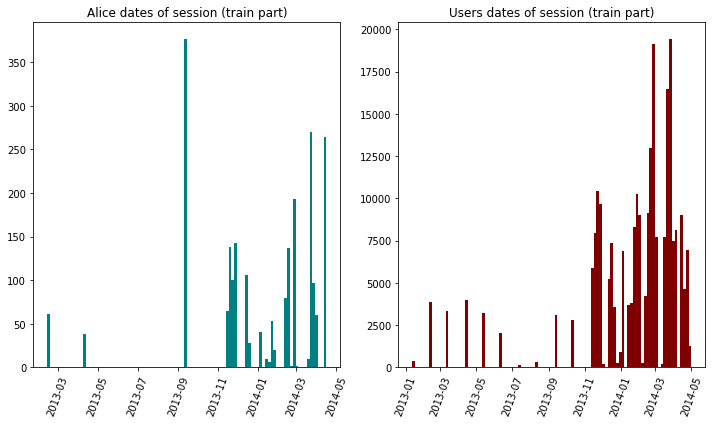

In [72]:
#1
fig, ax = plt.subplots(1, 2, figsize=(10,6))
ax[0].hist(train_df_dt[train_df_dt.target==1].session_strt, bins=100, color='teal', label='Alice')
ax[1].hist(train_df_dt[train_df_dt.target==0].session_strt, bins=100, color='maroon', label='Users')
ax[0].title.set_text('Alice dates of session (train part)')
ax[1].title.set_text('Users dates of session (train part)')
plt.setp( ax[0].xaxis.get_majorticklabels(), rotation=70 )
plt.setp( ax[1].xaxis.get_majorticklabels(), rotation=70 )
plt.tight_layout()
plt.show()

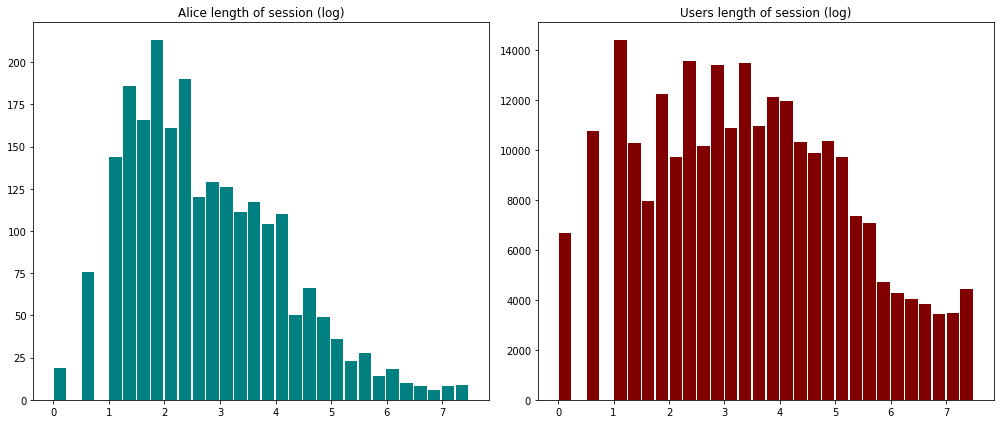

In [73]:
#2
fig, ax = plt.subplots(1, 2, figsize=(14,6))
ax[0].hist(np.log(train_df_dt[train_df_dt.target==1].session_len + 1), bins=30, color='teal', label='Alice', rwidth=0.9)
ax[1].hist(np.log(train_df_dt[train_df_dt.target==0].session_len + 1), bins=30, color='maroon', label='Users', rwidth=0.9)
ax[0].title.set_text('Alice length of session (log)')
ax[1].title.set_text('Users length of session (log)')
plt.tight_layout()
plt.show()

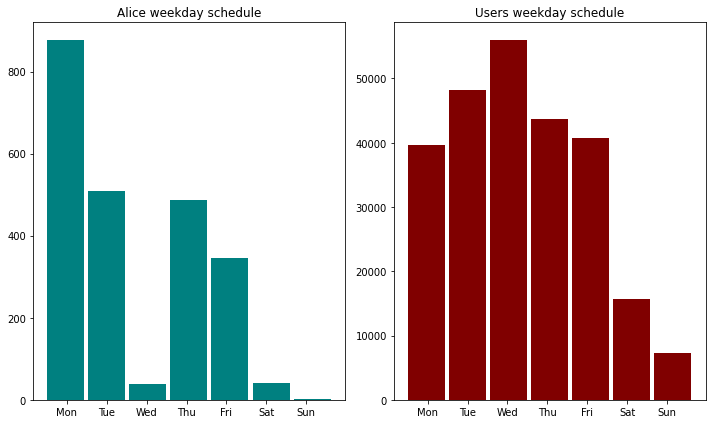

In [74]:
#3
fig, ax = plt.subplots(1, 2, figsize=(10,6))
ax[0].hist(train_df_dt[train_df_dt.target==1].weekday, bins=7, color='teal', label='Alice', rwidth=0.9)
ax[1].hist(train_df_dt[train_df_dt.target==0].weekday, bins=7, color='maroon', label='Users', rwidth=0.9)
ax[0].set_xticks(ticks=[i - 0.55 for i in np.linspace(1,6,7)])
ax[1].set_xticks(ticks=[i - 0.55 for i in np.linspace(1,6,7)])
ax[0].set_xticklabels(labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
ax[1].set_xticklabels(labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
ax[0].title.set_text('Alice weekday schedule')
ax[1].title.set_text('Users weekday schedule')
plt.tight_layout()
plt.show()

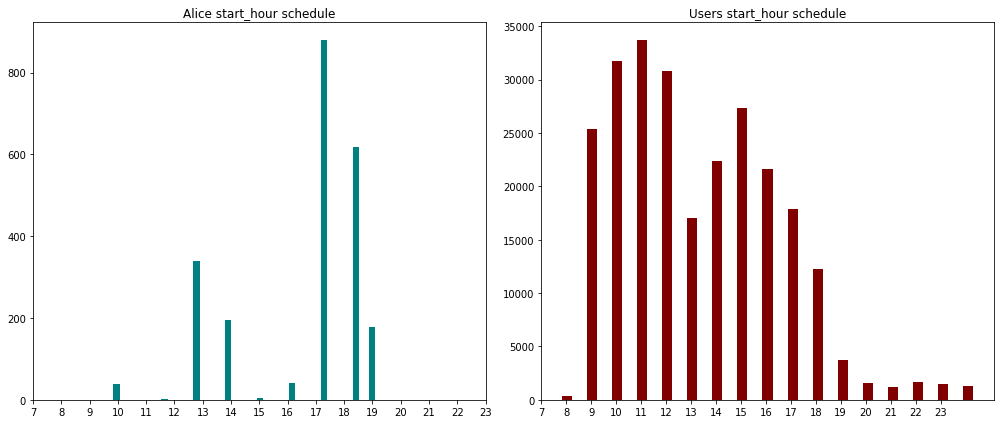

In [75]:
#4
fig, ax = plt.subplots(1, 2, figsize=(14,6))
ax[0].hist(train_df_dt[train_df_dt.target==1].start_hour, bins=17, color='teal', label='Alice', rwidth=0.4)
ax[1].hist(train_df_dt[train_df_dt.target==0].start_hour, bins=17, color='maroon', label='Users', rwidth=0.4)
ax[0].set_xticks(ticks=[i - 0.5 for i in np.linspace(7,22,17)])
ax[1].set_xticks(ticks=[i - 0.5 for i in np.linspace(7,22,17)])
ax[0].set_xticklabels(labels=['7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23'])
ax[1].set_xticklabels(labels=['7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23'])
ax[0].title.set_text('Alice start_hour schedule')
ax[1].title.set_text('Users start_hour schedule')
plt.tight_layout()
plt.show()

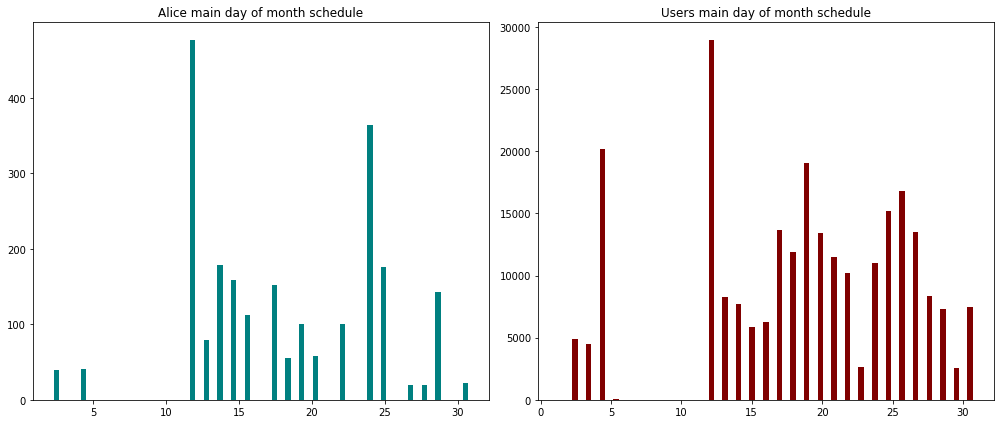

In [76]:
#5
fig, ax = plt.subplots(1, 2, figsize=(14,6))
ax[0].hist(train_df_dt[train_df_dt.target==1].day, bins=31, color='teal', label='Alice', rwidth=0.4)
ax[1].hist(train_df_dt[train_df_dt.target==0].day, bins=31, color='maroon', label='Users', rwidth=0.4)
ax[0].title.set_text('Alice main day of month schedule')
ax[1].title.set_text('Users main day of month schedule')
plt.tight_layout()
plt.show()

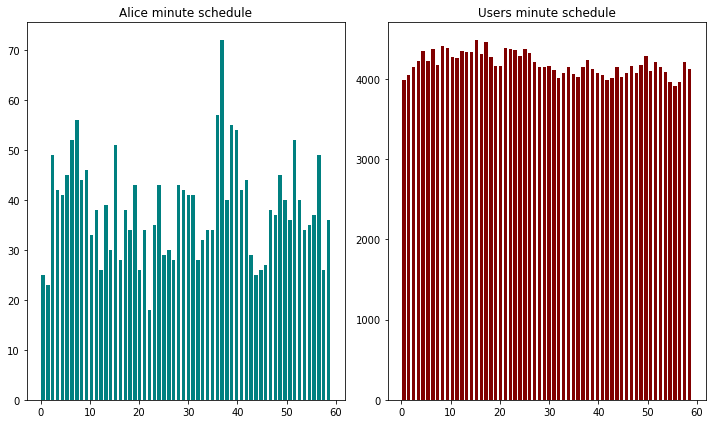

In [77]:
#6
fig, ax = plt.subplots(1, 2, figsize=(10,6))
ax[0].hist(train_df_dt[train_df_dt.target==1].minute, bins=60, color='teal', label='Alice', rwidth=0.7)
ax[1].hist(train_df_dt[train_df_dt.target==0].minute, bins=60, color='maroon', label='Users', rwidth=0.7)
ax[0].title.set_text('Alice minute schedule')
ax[1].title.set_text('Users minute schedule')
plt.tight_layout()
plt.show()

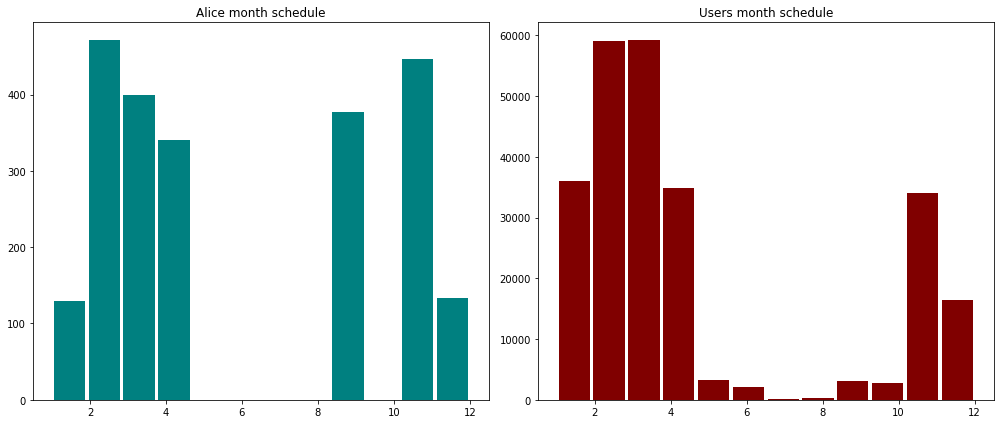

In [78]:
#7
fig, ax = plt.subplots(1, 2, figsize=(14,6))
ax[0].hist(train_df_dt[train_df_dt.target==1].month, bins=12, color='teal', label='Alice', rwidth=0.9)
ax[1].hist(train_df_dt[train_df_dt.target==0].month, bins=12, color='maroon', label='Users', rwidth=0.9)
ax[0].title.set_text('Alice month schedule')
ax[1].title.set_text('Users month schedule')
plt.tight_layout()
plt.show()

In [79]:
test_df_dt = time_operations(test_df)

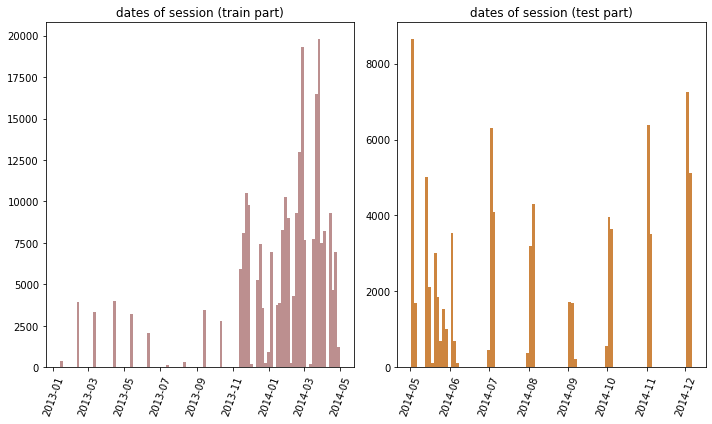

In [80]:
#1
fig, ax = plt.subplots(1, 2, figsize=(10,6))
ax[0].hist(train_df_dt.session_strt, bins=100, color='rosybrown')
ax[1].hist(test_df_dt.session_strt, bins=100, color='peru')
ax[0].title.set_text('dates of session (train part)')
ax[1].title.set_text('dates of session (test part)')
plt.setp( ax[0].xaxis.get_majorticklabels(), rotation=70 )
plt.setp( ax[1].xaxis.get_majorticklabels(), rotation=70 )
plt.tight_layout()
plt.show()

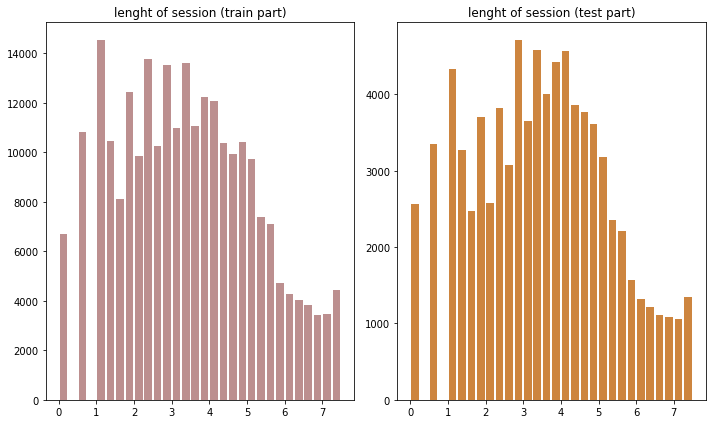

In [81]:
#2
fig, ax = plt.subplots(1, 2, figsize=(10,6))
ax[0].hist(np.log(train_df_dt.session_len + 1), bins=30, color='rosybrown', rwidth=0.8)
ax[1].hist(np.log(test_df_dt.session_len + 1), bins=30, color='peru', rwidth=0.8)
ax[0].title.set_text('lenght of session (train part)')
ax[1].title.set_text('lenght of session (test part)')
plt.tight_layout()
plt.show()

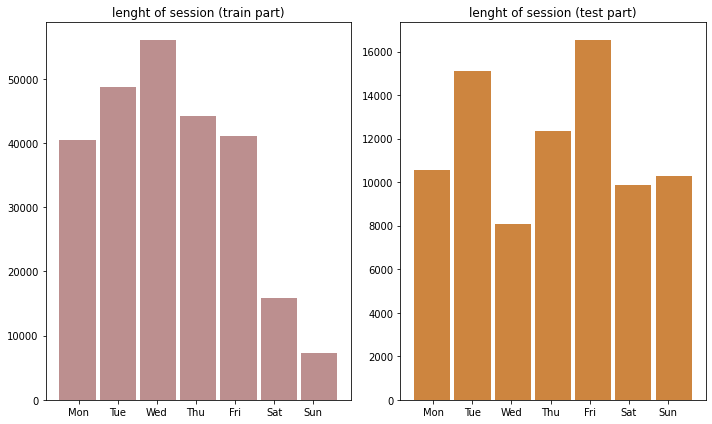

In [82]:
#3
fig, ax = plt.subplots(1, 2, figsize=(10,6))
ax[0].hist(train_df_dt.weekday, bins=7, color='rosybrown', rwidth=0.9)
ax[1].hist(test_df_dt.weekday, bins=7, color='peru', rwidth=0.9)
ax[0].set_xticks(ticks=[i - 0.55 for i in np.linspace(1,6,7)])
ax[1].set_xticks(ticks=[i - 0.55 for i in np.linspace(1,6,7)])
ax[0].set_xticklabels(labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
ax[1].set_xticklabels(labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
ax[0].title.set_text('lenght of session (train part)')
ax[1].title.set_text('lenght of session (test part)')
plt.tight_layout()
plt.show()

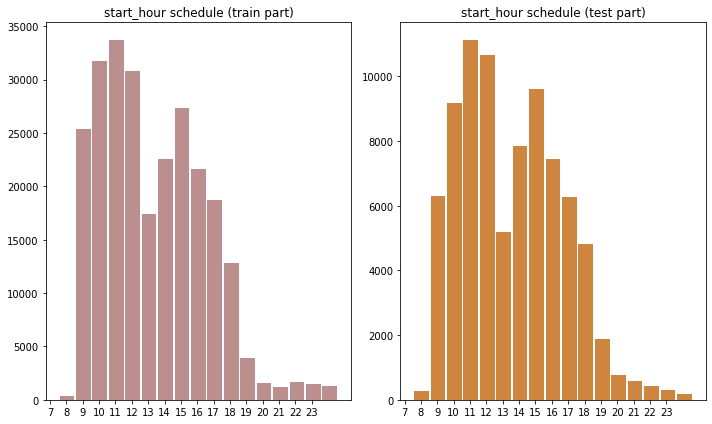

In [83]:
#4
fig, ax = plt.subplots(1, 2, figsize=(10,6))
ax[0].hist(train_df_dt.start_hour, bins=17, color='rosybrown', rwidth=0.9)
ax[1].hist(test_df_dt.start_hour, bins=17, color='peru', rwidth=0.9)
ax[0].set_xticks(ticks=[i - 0.5 for i in np.linspace(7,22,17)])
ax[1].set_xticks(ticks=[i - 0.5 for i in np.linspace(7,22,17)])
ax[0].set_xticklabels(labels=['7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23'])
ax[1].set_xticklabels(labels=['7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23'])
ax[0].title.set_text('start_hour schedule (train part)')
ax[1].title.set_text('start_hour schedule (test part)')
plt.tight_layout()
plt.show()

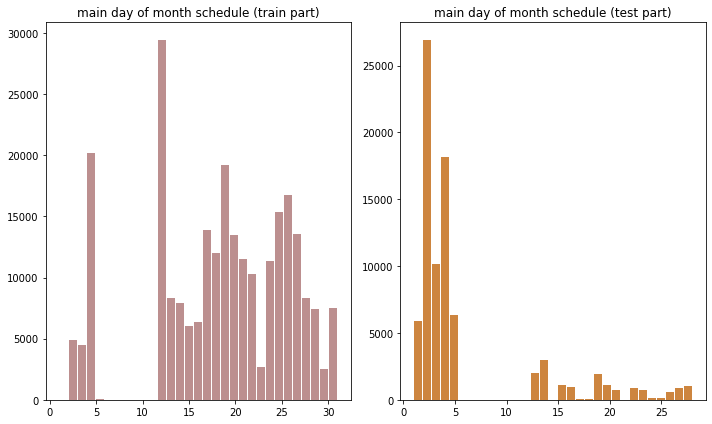

In [84]:
#5
fig, ax = plt.subplots(1, 2, figsize=(10,6))
ax[0].hist(train_df_dt.day, bins=31, color='rosybrown', rwidth=0.9)
ax[1].hist(test_df_dt.day, bins=31, color='peru', rwidth=0.9)
ax[0].title.set_text('main day of month schedule (train part)')
ax[1].title.set_text('main day of month schedule (test part)')
plt.tight_layout()
plt.show()

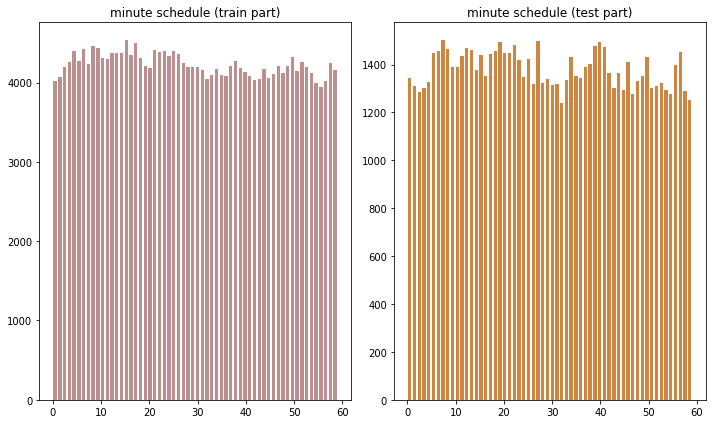

In [85]:
#6
fig, ax = plt.subplots(1, 2, figsize=(10,6))
ax[0].hist(train_df_dt.minute, bins=60, color='rosybrown', rwidth=0.7)
ax[1].hist(test_df_dt.minute, bins=60, color='peru', rwidth=0.7)
ax[0].title.set_text('minute schedule (train part)')
ax[1].title.set_text('minute schedule (test part)')
plt.tight_layout()
plt.show()

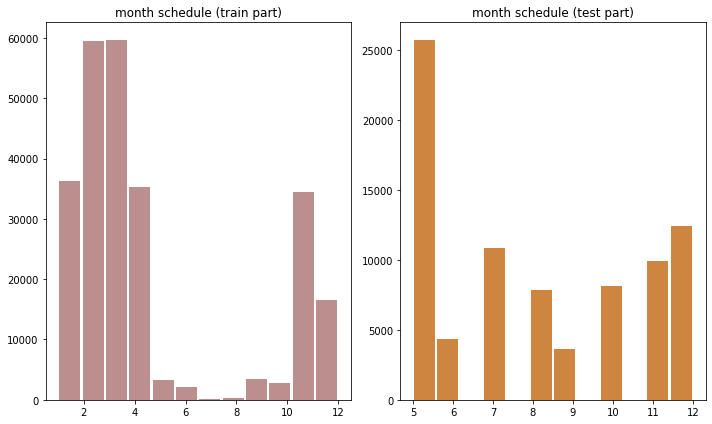

In [86]:
#7
fig, ax = plt.subplots(1, 2, figsize=(10,6))
ax[0].hist(train_df_dt.month, bins=12, color='rosybrown', rwidth=0.9)
ax[1].hist(test_df_dt.month, bins=12, color='peru', rwidth=0.9)
ax[0].title.set_text('month schedule (train part)')
ax[1].title.set_text('month schedule (test part)')
plt.tight_layout()
plt.show()